## IMPORTING CLEAN DATA & LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# for parallelization
from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray()

# models 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from xgboost import XGBClassifier
# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
# from keras.layers import Flatten
# from keras.layers import GlobalMaxPooling1D
# from keras.layers.embeddings import Embedding
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.text import Tokenizer

# Make the notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

# evaluation
from sklearn import metrics

%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

X_train = X_train.toarray()
X_test  = X_test.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reducing Number of Datapoints for better model training times
X_train = np.resize(X_train, (100000, 1000))
y_train = np.resize(y_train, (100000,))
X_test  = np.resize(X_test, (42000, 1000))
y_test  = np.resize(y_test, (42000,))

# Note: Still stratified 

In [4]:
# Helper Function for evaluation 
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)
    auc = metrics.roc_auc_score(y_test, y_predict)

    # Plot ROC for this label
    plt.plot(fpr,tpr,label="AUC = "+ "{:.2f}".format(auc))
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## Naive Bayes

### DEFAULT


MODEL: Naive Bayes
Accuracy:  0.7003457943925233
Precision:  0.6777160693680008
Recall:  0.7633835479376478
F1 Score:  0.7180035180299031


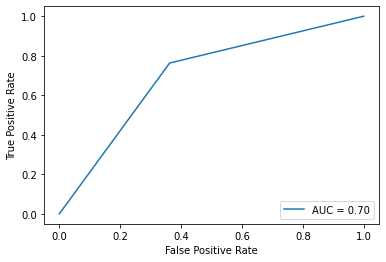

In [51]:
nb = GaussianNB()

with parallel_backend("ray"):
    nb.fit(X_train, y_train)

y_predict = nb.predict(X_test)
evaluate(y_test, y_predict, 'Naive Bayes')

## Long Short Term Memory Model (LSTM)

In [3]:
# Create validation set from 10% of the training set
X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(X_train, y_train, train_size=0.5)

### Defining the model

In [4]:
# Implement a simple, single layer LSTM model
model = keras.models.Sequential([
    
    # Embedding layer maps words to dense vectors
    keras.layers.Embedding(1000, 64),
    
    # LSTM layer with 64 units
    keras.layers.LSTM(64),
    
    # Fully connceted layer performs classification on the LSTM output
    keras.layers.Dense(1, activation="sigmoid")
])

2022-05-18 12:59:19.268814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Specifying the loss and optimiser

In [5]:
# Compile the model, specifying optimsier, loss and metrics
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

### Training the model

In [ ]:
# Train the model for 3 epochs
with parallel_backend("ray"):
    model.fit(X_train_valid, y_train_valid, batch_size=10, epochs=5, validation_data=(X_test_valid, y_test_valid))

In [ ]:
model.summary()

# Convolutional Neural Network (CNN)

### Defining the model

In [ ]:
# model = Sequential()

# embedding_layer = Embedding(1000, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# model.add(embedding_layer)

# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# XG Boost 

/Users/mudit/opt/anaconda3/envs/comp5318/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

MODEL: XGBoost
Accuracy:  0.7226904761904762
Precision:  0.705683859941277
Recall:  0.7655700294760863
F1 Score:  0.7344081362734591


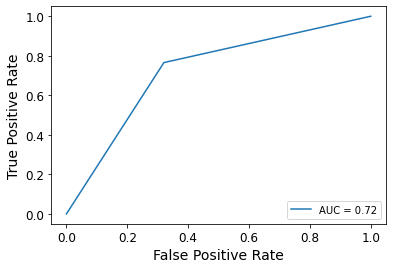

In [12]:
with parallel_backend("ray"):
    xgb_model = XGBClassifier(max_depth = 6, n_estimators = 1000).fit(X_train, y_train)
y_predict = xgb_model.predict(X_test)
evaluate(y_test, y_predict, 'XGBoost')

# Logistic Regression


MODEL: Logistic Regression
Accuracy:  0.7307142857142858
Precision:  0.7160696826948716
Recall:  0.7660454502234477
F1 Score:  0.7402149944873209


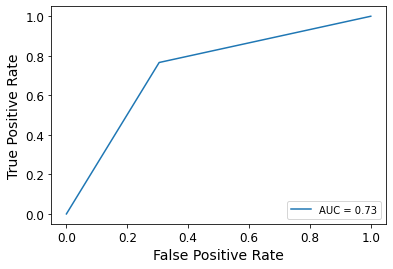

In [5]:
lr = LogisticRegression()

with parallel_backend("ray"):
    lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)
evaluate(y_test, y_predict, 'Logistic Regression')

# Support Vector Machine

In [6]:
svm = SVC()

with parallel_backend("ray"):
    svm.fit(X_train, y_train)

y_predict = svm.predict(X_test)
evaluate(y_test, y_predict, 'SVM')

### PARAMETER TUNING

In [52]:
# TODO ARYAN